In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
topwear = ['Bra', 'Dresses', 'Innerwear Vests', 'Jackets', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Shirts', 'Suspenders', 'Sweaters', 'Sweatshirts', 'Tops', 'Tshirts', 'Tunics']
bottomwear = ['Briefs', 'Capris', 'Jeans', 'Leggings', 'Shorts', 'Skirts', 'Track Pants', 'Trousers', 'Trunk']
shoes = ['Casual Shoes', 'Flats', 'Flip Flops', 'Formal Shoes', 'Heels', 'Sandals', 'Sports Shoes']

In [ ]:
class FashionResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
def inspect_checkpoint(model_path):
    checkpoint = torch.load(model_path)
    print("\nCheckpoint contents:")
    for key in checkpoint.keys():
        print(f"- {key}")
    return checkpoint

In [ ]:
def load_model(model_path):
    checkpoint = inspect_checkpoint(model_path)

    # classify images with the same amount as training data
    num_classes = 30
    model = FashionResNet(num_classes)

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()

    # Class names defined from
    class_names =  ['Bra', 'Briefs', 'Capris', 'Casual Shoes', 'Dresses', 'Flats', 'Flip Flops', 'Formal Shoes', 'Heels', 'Innerwear Vests', 'Jackets', 'Jeans', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Leggings', 'Sandals', 'Shirts', 'Shorts', 'Skirts', 'Sports Shoes', 'Suspenders', 'Sweaters', 'Sweatshirts', 'Tops', 'Track Pants', 'Trousers', 'Trunk', 'Tshirts', 'Tunics']

    return model, class_names

In [ ]:
def predict_image(image_path, model, class_names):
    # single prediction
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # get the image and show
    image = Image.open(image_path).convert('RGB')
    np_image = np.array(image)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # predict
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # get top 3 predictions
        top3_prob, top3_indices = torch.topk(probabilities, 3)

        predictions = []
        for prob, idx in zip(top3_prob, top3_indices):
            predictions.append({
                'class': class_names[idx],
                'probability': prob.item()
            })

    return predictions


In [ ]:
print("Loading model...")
model_path = '/content/drive/MyDrive/ML Project Team/saved_models/expanded_final_model.pth'
model, class_names = load_model(model_path)
print(f"Model loaded. Available classes: {class_names}")

Loading model...


<ipython-input-6-c2d50243a8db>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



Checkpoint contents:
- epoch
- model_state_dict
- optimizer_state_dict
- train_acc
- val_acc
- classes
- class_to_idx


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.6MB/s]


Model loaded. Available classes: ['Bra', 'Briefs', 'Capris', 'Casual Shoes', 'Dresses', 'Flats', 'Flip Flops', 'Formal Shoes', 'Heels', 'Innerwear Vests', 'Jackets', 'Jeans', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Leggings', 'Sandals', 'Shirts', 'Shorts', 'Skirts', 'Sports Shoes', 'Suspenders', 'Sweaters', 'Sweatshirts', 'Tops', 'Track Pants', 'Trousers', 'Trunk', 'Tshirts', 'Tunics']


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def classify_dominant_color(image_path):
    # load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at the path: {image_path}")

    # convert image to rgb
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # change ot grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)  # Invert to get clothing area

    # get contours to remove the background
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # apply mask
    clothing_region = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

    # get rid of background pixels
    non_background_pixels = clothing_region[np.any(clothing_region > 0, axis=-1)]

    if non_background_pixels.size == 0:
        raise ValueError("No clothing region detected. Ensure the image has distinguishable clothing.")

    # Use KMeans to find the dominant color
    kmeans = KMeans(n_clusters=1, random_state=0)
    kmeans.fit(non_background_pixels)
    dominant_color = kmeans.cluster_centers_[0]

    # convert the images to rgb
    dominant_color_rgb = tuple(map(int, dominant_color))

    return dominant_color_rgb

In [ ]:
import random

def get_complementary_color_with_tolerance(rgb, tolerance=20):
    # calculate a corresponding rgb that has a bit of leniency
    if not all(0 <= value <= 255 for value in rgb):
        raise ValueError("RGB values must be in the range 0-255.")
    if not (0 <= tolerance <= 255):
        raise ValueError("Tolerance must be between 0 and 255.")

    # get the exact value
    exact_complementary_color = tuple(255 - value for value in rgb)

    # allow for some deviation
    lenient_complementary_color = tuple(
        max(0, min(255, exact_value + random.randint(-tolerance, tolerance)))
        for exact_value in exact_complementary_color
    )
    return lenient_complementary_color

In [ ]:
csv_dir = '/content/drive/MyDrive/ML Project Team/dataset/myntradataset/'
os.chdir(csv_dir)
!ls
closet = pd.read_csv('closet_csv')
closet.head()

'7345 (1).jpg'	 7350.jpg  '9993 (1).jpg'   closet_csv		  styles.csv
'7345 (2).jpg'	 7392.jpg  '9993 (2).jpg'   filtered_styles.csv   test_styles.csv
'7345 (3).jpg'	 7519.jpg  '9993 (3).jpg'  'fixedimages (3)'	  workingbackups
'7345 (4).jpg'	 9812.jpg  '9993 (4).jpg'   images
'7345 (5).jpg'	 9960.jpg  '9993 (5).jpg'   newimages
 7345.jpg	 9990.jpg   9993.jpg	   'newimages (1)'


,filename,article_type,confidence,dominant_color_rgb,category
0,10718.jpg,Tshirts,0.580926,"(249, 140, 113)",topwear
1,10783.jpg,Sports Shoes,0.999751,"(198, 197, 203)",shoes
2,10341.jpg,Tshirts,0.879071,"(179, 109, 100)",topwear
3,10179.jpg,Sandals,0.555109,"(73, 58, 87)",shoes
4,10809.jpg,Tshirts,0.957934,"(87, 78, 70)",topwear


# FINDING MATCHING PIECES

In [ ]:
def find_complementary_pieces(self, closet_df, color_tolerance=20):
    # Define the categories we want to match against
    categories = ['topwear', 'bottomwear', 'shoes']
    needed_categories = [cat for cat in categories if (cat != self.category and self.article_type != 'Briefs')]
    target_color = get_complementary_color_with_tolerance(self.dominant_color_rgb, color_tolerance)

    # get the color differences
    def color_difference(row_color, target_color):
        if isinstance(row_color, str):
            row_color = eval(row_color)
        return sum((a - b) ** 2 for a, b in zip(row_color, target_color)) ** 0.5

    complementary_pieces = []

    for needed_category in needed_categories:
        # get only the categories that we need
        category_df = closet_df[closet_df['category'] == needed_category].copy()

        if not category_df.empty:
            category_df['color_diff'] = category_df['dominant_color_rgb'].apply(
                lambda x: color_difference(x, target_color)
            )

            # get the best match
            best_match = category_df.nsmallest(1, 'color_diff').iloc[0]

            complementary_piece = FashionArticle(
                filename=best_match['filename'],
                article_type=best_match['article_type'],
                confidence=best_match['confidence'],
                dominant_color_rgb=eval(best_match['dominant_color_rgb'])
                    if isinstance(best_match['dominant_color_rgb'], str)
                    else best_match['dominant_color_rgb'],
                category=best_match['category']
            )

            complementary_pieces.append(complementary_piece)

    return tuple(complementary_pieces)

In [ ]:
class FashionArticle:
    def __init__(self, filename, article_type, confidence, dominant_color_rgb, category):
        self.filename = filename
        self.article_type = article_type
        self.confidence = confidence
        self.dominant_color_rgb = dominant_color_rgb
        self.category = category

    def __str__(self):
        return f"\nFilename: {self.filename}\nArticle: {self.article_type} ({self.confidence:.2%})\nColor: {self.dominant_color_rgb}\nCategory: {self.category}"

# INPUTTING TEST IMAGES


Please upload an image...


Saving 9960.jpg to 9960 (1).jpg

Predicting class for 9960 (1).jpg:


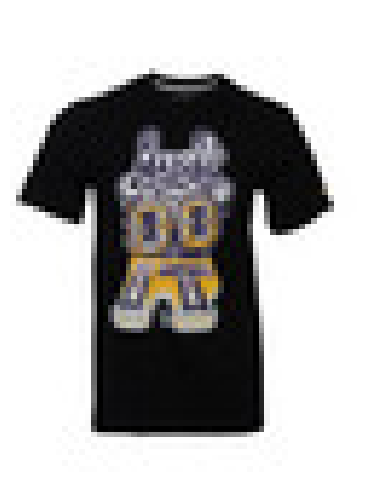


Top 3 predictions:
1. Tshirts - 99.99%
2. Sweatshirts - 0.01%
3. Jackets - 0.00%

Uploaded article details: 
Filename: 9960 (1).jpg
Article: Tshirts (99.99%)
Color: (55, 52, 51)
Category: topwear

Recommended complementary pieces:

Filename: 43917.jpg
Article: Jeans (65.05%)
Color: (202, 199, 192)
Category: bottomwear

Filename: 59037.jpg
Article: Heels (28.76%)
Color: (192, 206, 188)
Category: shoes


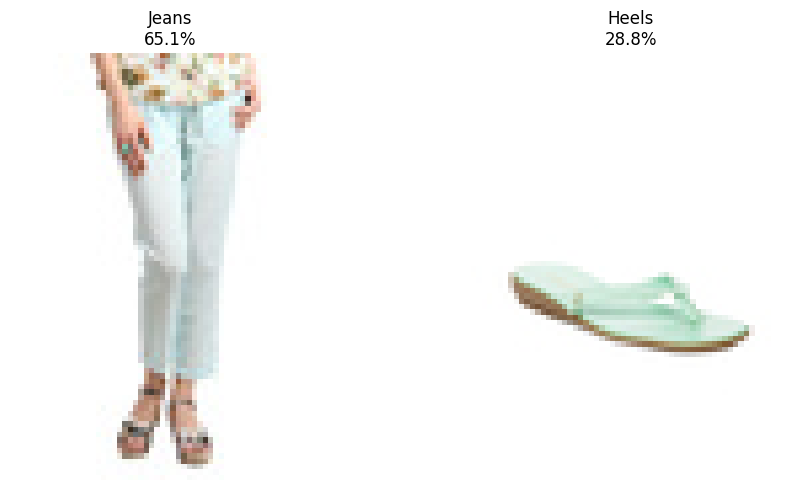

In [ ]:
def process_uploaded_image():
    print("\nPlease upload an image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nPredicting class for {filename}:")
        predictions = predict_image(filename, model, class_names)
        article_type = predictions[0]['class']
        try:
            dominant_color = classify_dominant_color(filename)
        except Exception as e:
            dominant_color = None
            print(f"Could not determine dominant color: {str(e)}")
            continue

        if article_type in topwear:
            category = 'topwear'
        elif article_type in bottomwear:
            category = 'bottomwear'
        elif article_type in shoes:
            category = 'shoes'
        else:
            category = 'other'
            print("This article type cannot be matched with complementary pieces.")
            continue

        article = FashionArticle(filename, article_type, predictions[0]['probability'],
                               dominant_color, category)

        # get predictions and article types
        print("\nTop 3 predictions:")
        for i, pred in enumerate(predictions, 1):
            print(f"{i}. {pred['class']} - {pred['probability']:.2%}")
        print("\nUploaded article details:", article)

        try:
            complementary_pieces = find_complementary_pieces(article, closet)
            closet_img_dir = '/content/drive/MyDrive/ML Project Team/dataset/myntradataset/newimages/'
            os.chdir(closet_img_dir)

            print("\nRecommended complementary pieces:")

            # show the figures for the complementary
            fig, axes = plt.subplots(1, len(complementary_pieces), figsize=(10, 5))
            if len(complementary_pieces) == 1:
                axes = [axes]

            for idx, piece in enumerate(complementary_pieces):
                print(piece)
                img_path = os.path.join(closet_img_dir, piece.filename)
                img = plt.imread(img_path)
                axes[idx].imshow(img)
                axes[idx].axis('off')
                axes[idx].set_title(f"{piece.article_type}\n{piece.confidence:.1%}")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\nError finding complementary pieces: {str(e)}")

# Interactive testing loop
while True:
    user_input = input("\nWould you like to test an image? (yes/no): ")
    if user_input.lower() != 'yes':
        break
    process_uploaded_image()

print("Done!")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import os
from matplotlib.colors import to_rgb

In [ ]:
def color_distance(rgb1, rgb2):
    return np.sqrt(sum((a - b) ** 2 for a, b in zip(rgb1, rgb2)))

def is_color_match(predicted_rgb, ground_truth_color, tolerance=190):
    try:
        ground_truth_rgb = to_rgb(ground_truth_color)  # Convert ground truth color name to RGB
        ground_truth_rgb_255 = tuple(int(c * 255) for c in ground_truth_rgb)
        distance = color_distance(predicted_rgb, ground_truth_rgb_255)
        return distance <= tolerance
    except ValueError:
        return False  # If ground truth color is invalid

#EVALUATIONS: Testing the model accuracies on color and article type

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report

def evaluate_model_with_csvs_filtered(closet_csv_path, truths_csv_path):
    # Define valid article types
    valid_articles = topwear + bottomwear + shoes

    # Load and prepare data
    closet_df = pd.read_csv(closet_csv_path)
    truths_df = pd.read_csv(truths_csv_path)
    closet_df['id'] = closet_df['filename'].str.extract(r'(\d+)').astype(int)

    # Filter and merge
    filtered_truths = truths_df[truths_df['articleType'].isin(valid_articles)]
    merged_df = pd.merge(closet_df, filtered_truths, on='id', how='inner', suffixes=('_predicted', '_true'))
    filtered_df = merged_df[
        (merged_df['article_type'].isin(valid_articles)) &
        (merged_df['articleType'].isin(valid_articles))
    ]

    def get_category(article_type):
        if article_type in topwear:
            return 'topwear'
        elif article_type in bottomwear:
            return 'bottomwear'
        elif article_type in shoes:
            return 'shoes'
        return 'other'

    # Add category columns
    filtered_df['true_category'] = filtered_df['articleType'].apply(get_category)
    filtered_df['pred_category'] = filtered_df['article_type'].apply(get_category)

    # Calculate overall metrics
    print("\n=== Overall Metrics ===")
    overall_accuracy = accuracy_score(filtered_df['articleType'], filtered_df['article_type'])
    overall_precision = precision_score(filtered_df['articleType'], filtered_df['article_type'],
                                     average='macro', zero_division=0)
    print(f"Overall Accuracy: {overall_accuracy:.2%}")
    print(f"Overall Precision: {overall_precision:.2%}")

    # Plot complete confusion matrix for all article types
    plt.figure(figsize=(20, 15))
    all_articles_conf_matrix = confusion_matrix(
        filtered_df['articleType'],
        filtered_df['article_type'],
        labels=valid_articles
    )
    sns.heatmap(all_articles_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=valid_articles,
                yticklabels=valid_articles)
    plt.title('Complete Confusion Matrix (All Article Types)')
    plt.xlabel('Predicted Article Type')
    plt.ylabel('True Article Type')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Plot category-level confusion matrix
    plt.figure(figsize=(10, 8))
    categories = ['topwear', 'bottomwear', 'shoes']
    cat_conf_matrix = confusion_matrix(
        filtered_df['true_category'],
        filtered_df['pred_category'],
        labels=categories
    )
    sns.heatmap(cat_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories,
                yticklabels=categories)
    plt.title('Category-Level Confusion Matrix')
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.tight_layout()
    plt.show()

    # plot confusion matrices per category
    for category in categories:
        category_mask = filtered_df['true_category'] == category
        category_df = filtered_df[category_mask]

        if len(category_df) > 0:
            # get unique article types
            if category == 'topwear':
                valid_articles_cat = topwear
            elif category == 'bottomwear':
                valid_articles_cat = bottomwear
            else:
                valid_articles_cat = shoes

            # find metrics
            cat_accuracy = accuracy_score(
                category_df['articleType'],
                category_df['article_type']
            )
            cat_precision = precision_score(
                category_df['articleType'],
                category_df['article_type'],
                average='macro',
                zero_division=0
            )

            print(f"\n=== {category.upper()} ===")
            print(f"Number of items: {len(category_df)}")
            print(f"Accuracy: {cat_accuracy:.2%}")
            print(f"Precision: {cat_precision:.2%}")

            # Plot confusion matrix for this category
            plt.figure(figsize=(12, 10))
            cat_articles_conf_matrix = confusion_matrix(
                category_df['articleType'],
                category_df['article_type'],
                labels=valid_articles_cat
            )
            sns.heatmap(cat_articles_conf_matrix, annot=True, fmt='d', cmap='Blues',
                        xticklabels=valid_articles_cat,
                        yticklabels=valid_articles_cat)
            plt.title(f'Confusion Matrix for {category.upper()}')
            plt.xlabel('Predicted Article Type')
            plt.ylabel('True Article Type')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

    print("\n=== Detailed Classification Report ===")
    print(classification_report(
        filtered_df['true_category'],
        filtered_df['pred_category'],
        labels=categories
    ))


    # color classifications
    filtered_df['pred_color_rgb'] = filtered_df['dominant_color_rgb'].apply(eval)  # Convert string to tuple
    filtered_df['color_match'] = filtered_df.apply(
        lambda row: is_color_match(row['pred_color_rgb'], row['baseColour']), axis=1
    )
    color_accuracy = filtered_df['color_match'].mean()

    print("\n=== Color Prediction Metrics ===")
    print(f"Color Prediction Accuracy: {color_accuracy:.2%}")

    return filtered_df


=== Overall Metrics ===
Overall Accuracy: 56.13%
Overall Precision: 41.84%


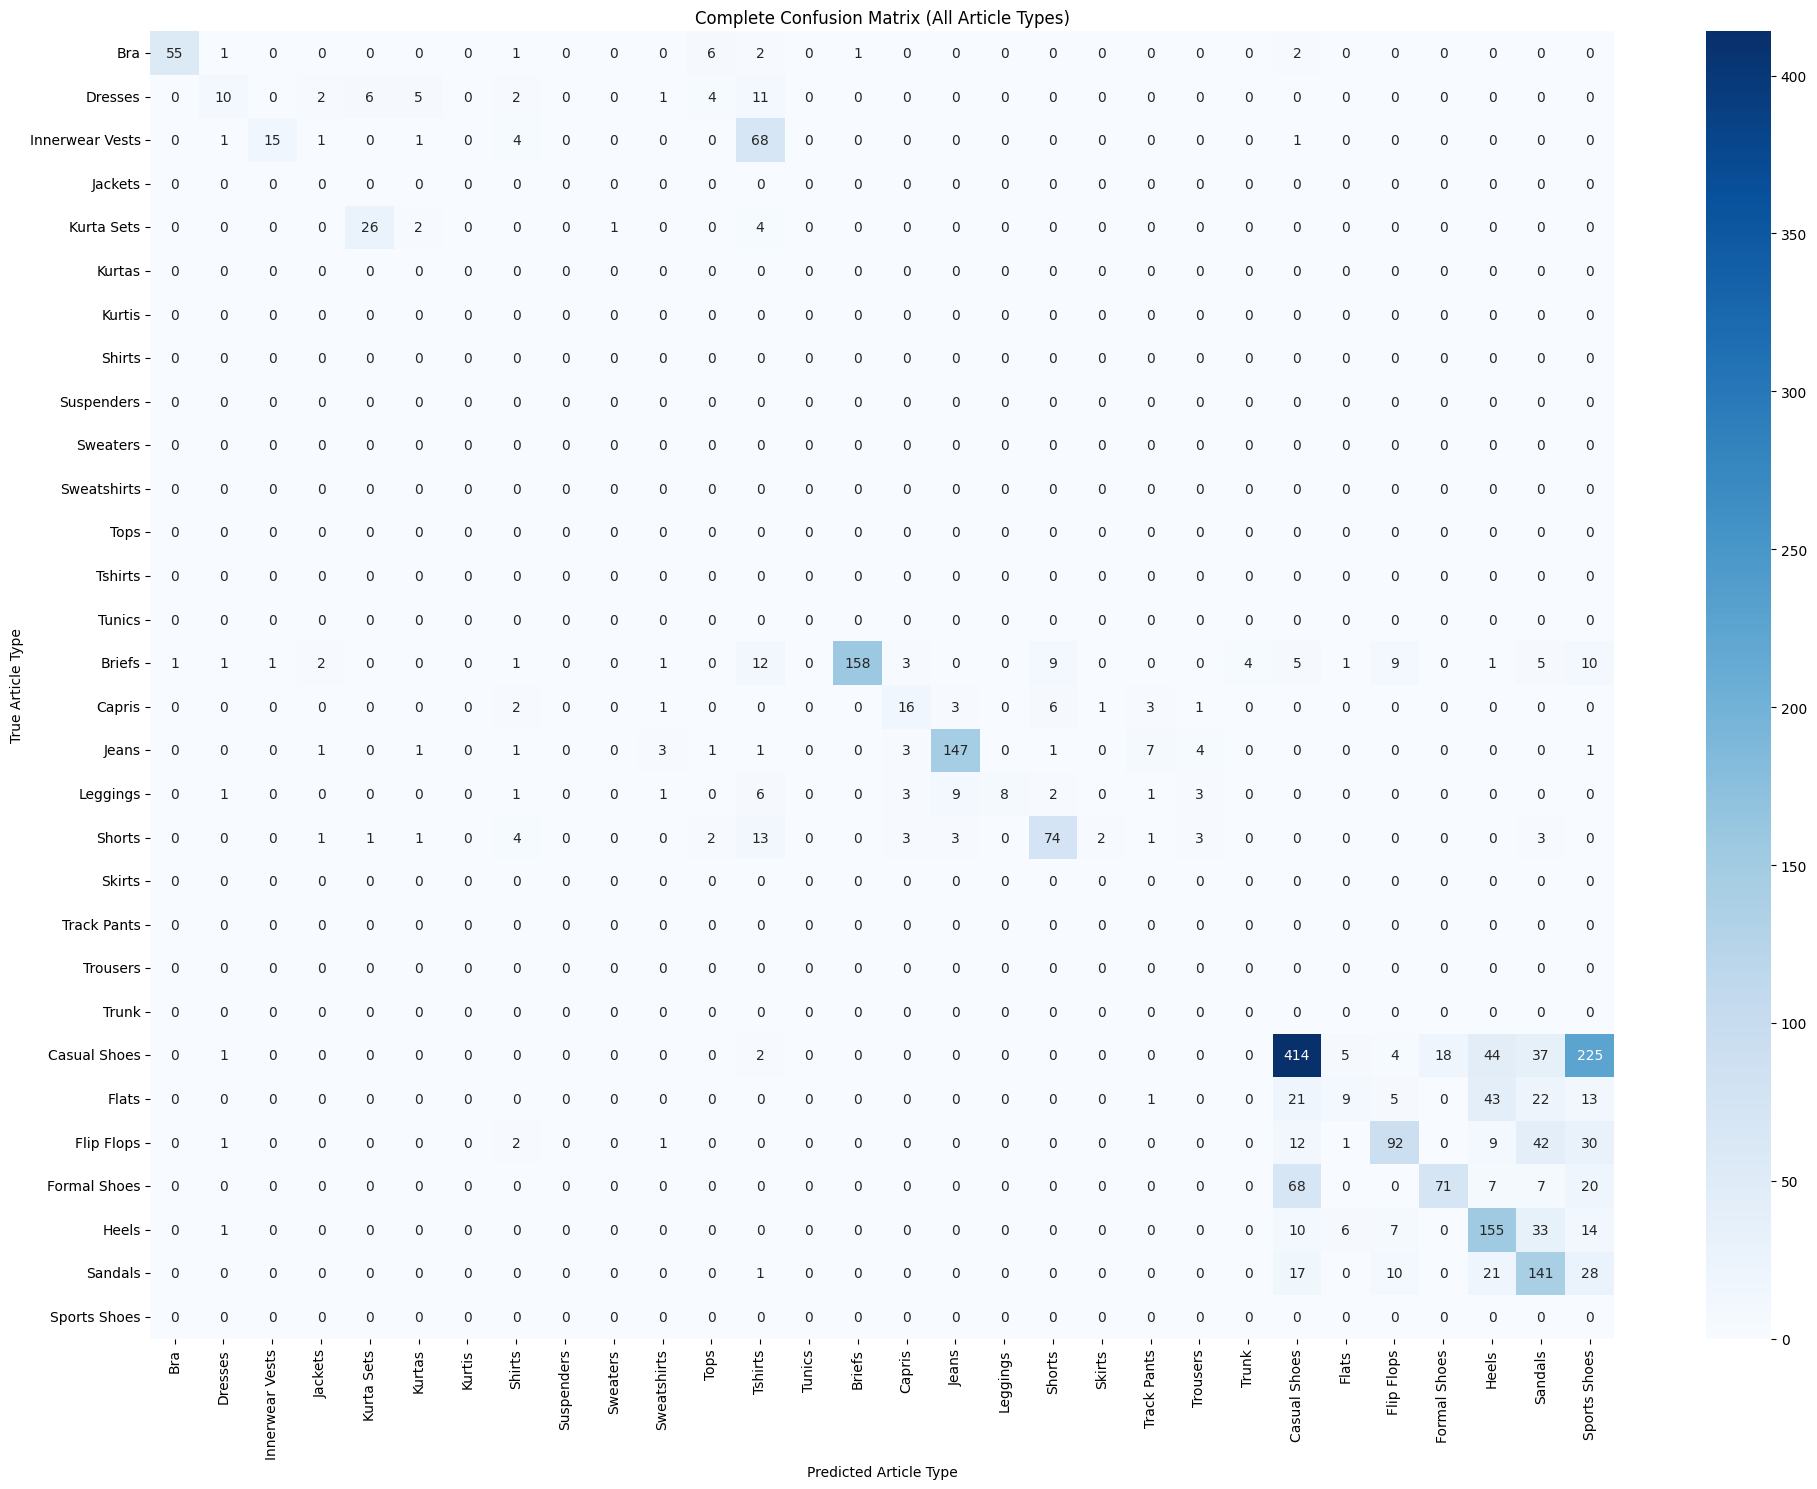

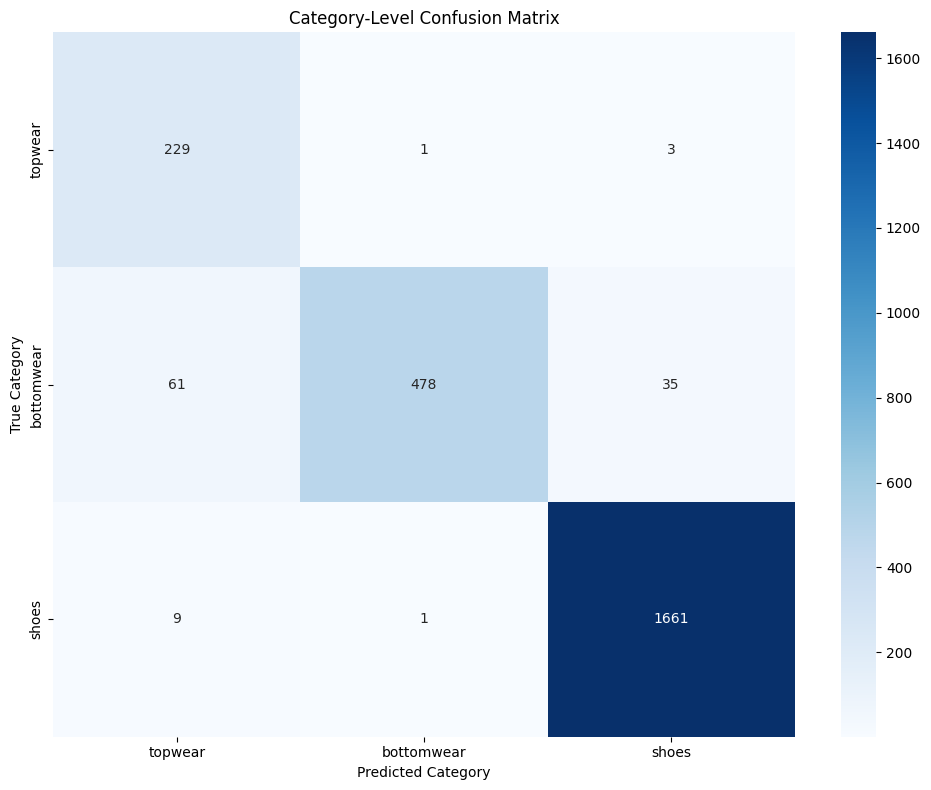


=== TOPWEAR ===
Number of items: 233
Accuracy: 45.49%
Precision: 28.04%


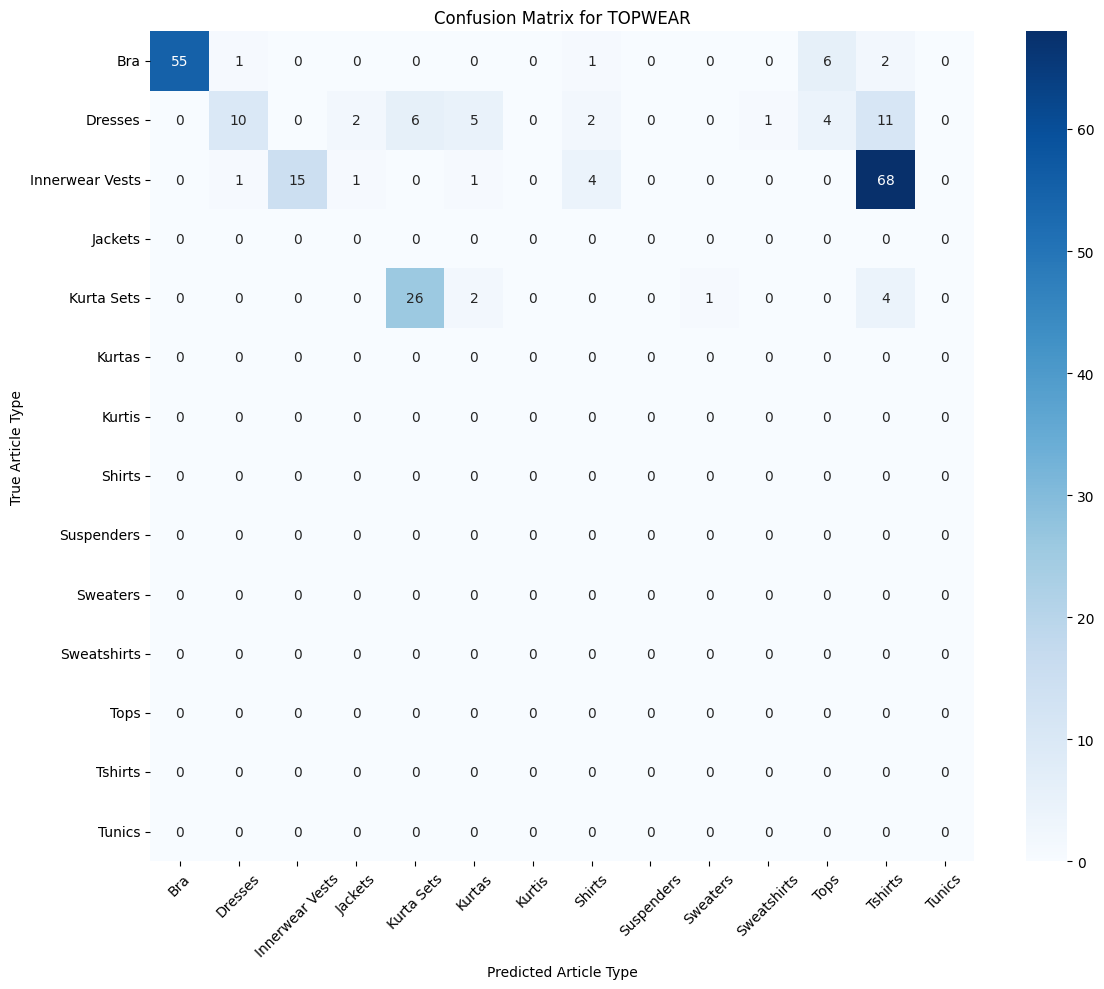


=== BOTTOMWEAR ===
Number of items: 574
Accuracy: 70.21%
Precision: 17.13%


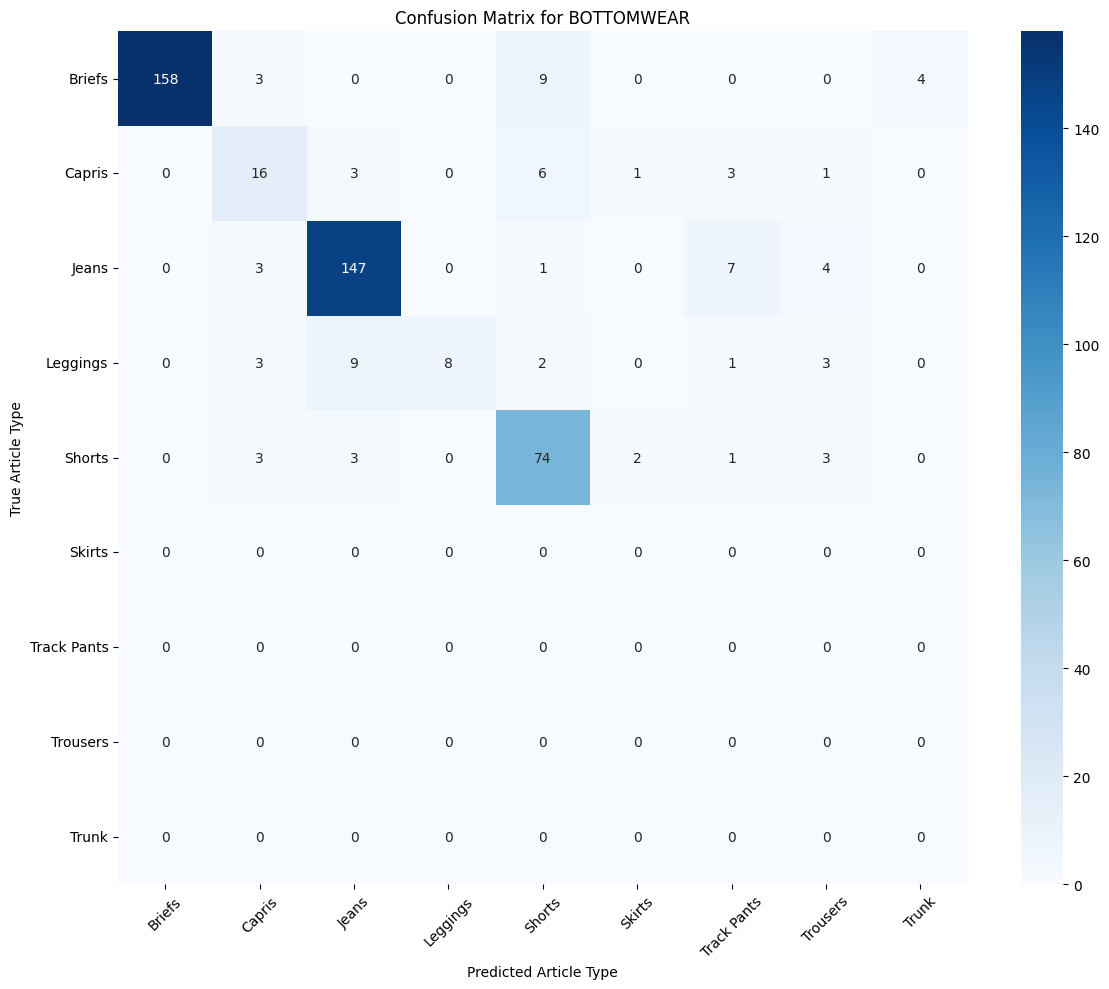


=== SHOES ===
Number of items: 1671
Accuracy: 52.78%
Precision: 31.88%


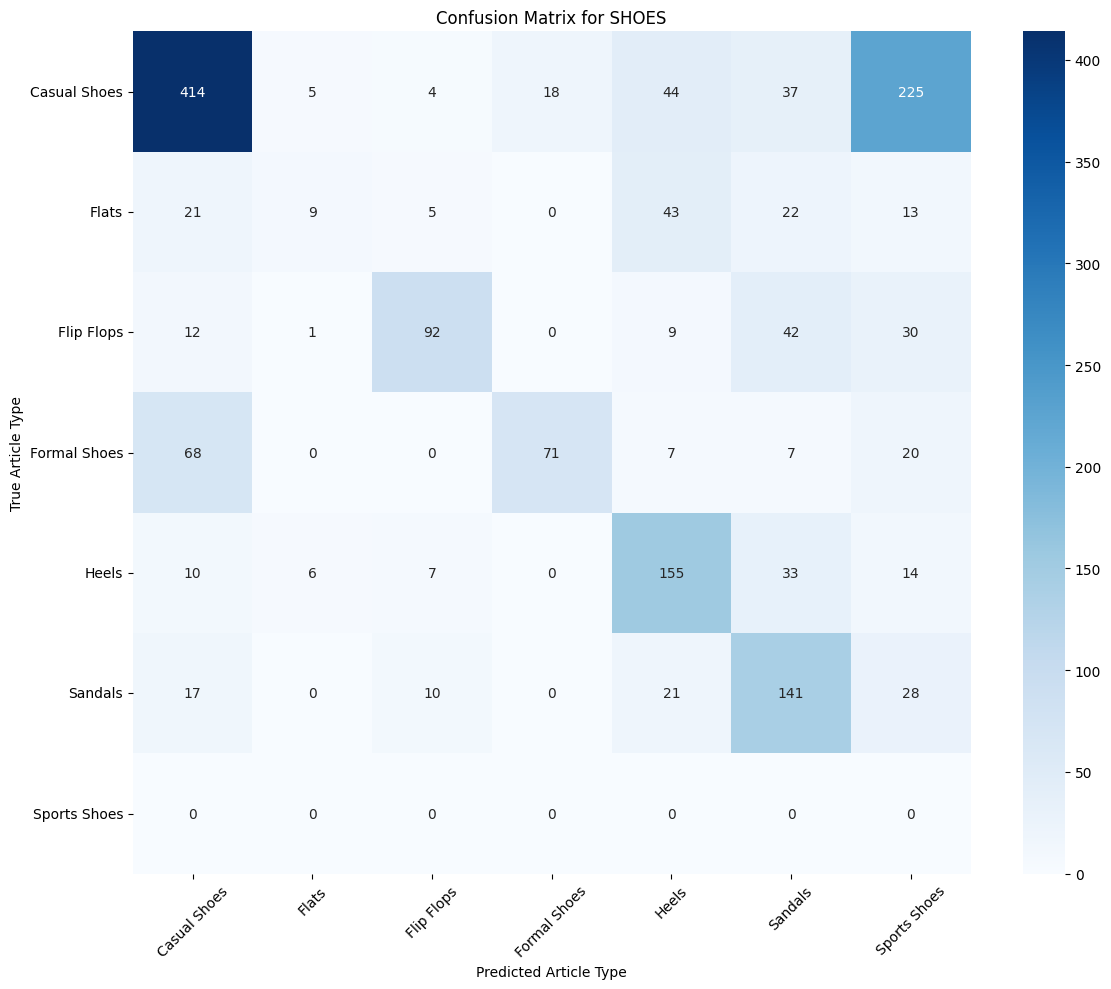


=== Detailed Classification Report ===
              precision    recall  f1-score   support

     topwear       0.77      0.98      0.86       233
  bottomwear       1.00      0.83      0.91       574
       shoes       0.98      0.99      0.99      1671

    accuracy                           0.96      2478
   macro avg       0.91      0.94      0.92      2478
weighted avg       0.96      0.96      0.96      2478


=== Color Prediction Metrics ===
Color Prediction Accuracy: 68.60%


In [ ]:
# closet csv is the results from the predictions
closet_csv_path = '/content/drive/MyDrive/ML Project Team/dataset/myntradataset/closet_csv'
test_styles_csv_path = '/content/drive/MyDrive/ML Project Team/dataset/filtered_styles.csv'

# Run the evaluation
results_df = evaluate_model_with_csvs_filtered(closet_csv_path, test_styles_csv_path)